# Final Project

In [338]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [339]:
paths = list(Path("Smart Building").rglob("*.*"))

co2_paths = [path for path in paths if path.name == 'co2.csv']
humidity_paths = [path for path in paths if path.name == 'humidity.csv']
temperature_paths = [path for path in paths if path.name == 'temperature.csv']
light_paths = [path for path in paths if path.name == 'light.csv']
pir_paths = [path for path in paths if path.name == 'pir.csv']

In [340]:
dataset = []
for light_path, temperature_path, co2_path, pir_path, humidity_path in zip(light_paths, temperature_paths, co2_paths, pir_paths, humidity_paths):
    light_df = pd.read_csv(light_path, names=['unix_time', 'light'], index_col='unix_time')
    temperature_df = pd.read_csv(temperature_path, names=['unix_time', 'temperature'], index_col='unix_time')
    co2_df = pd.read_csv(co2_path, names=['unix_time', 'co2'], index_col='unix_time')
    humidity_df = pd.read_csv(humidity_path, names=['unix_time', 'humidity'], index_col='unix_time')
    pir_df = pd.read_csv(pir_path, names=['unix_time', 'pir'], index_col='unix_time')
    
    df = pd.concat([light_df, temperature_df, co2_df, pir_df, humidity_df], axis=1, join="inner")
    df['room'] = light_path.parent.name
    dataset.append(df)
data = pd.concat(dataset)

data.head()

,light,temperature,co2,pir,humidity,room
unix_time,,,,,,
1377299108,97.0,23.94,495.0,0.0,45.34,413
1377457084,103.0,23.48,459.0,0.0,52.75,413
1377457963,104.0,23.50,456.0,0.0,52.71,413
1377462175,105.0,23.54,446.0,0.0,52.43,413
1377464765,111.0,23.56,463.0,0.0,52.30,413


In [341]:
print("Percentage of data missing")
data.isnull().sum().sort_values(ascending = False)/len(data)*100

Percentage of data missing


light          0.0
temperature    0.0
co2            0.0
pir            0.0
humidity       0.0
room           0.0
dtype: float64

In [342]:
data = data.dropna()
data.head(10)

,light,temperature,co2,pir,humidity,room
unix_time,,,,,,
1377299108,97.0,23.94,495.0,0.0,45.34,413
1377457084,103.0,23.48,459.0,0.0,52.75,413
1377457963,104.0,23.50,456.0,0.0,52.71,413
1377462175,105.0,23.54,446.0,0.0,52.43,413
1377464765,111.0,23.56,463.0,0.0,52.30,413
1377467333,159.0,23.65,458.0,0.0,52.21,413
1377470795,162.0,23.93,473.0,0.0,51.76,413
1377475133,182.0,24.36,455.0,0.0,50.83,413
1377478615,225.0,24.75,456.0,0.0,49.87,413


In [343]:
data.shape

(135386, 6)

In [344]:
data["pir"] = data["pir"].apply(lambda x: 0 if x == 0 else 1)

data["pir"].describe()

count    135386.000000
mean          0.067193
std           0.250357
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: pir, dtype: float64

In [345]:
from collections import Counter


def detectOutliers(data, n, features):
    outlier_rows = []
    for col in features:
        Q1 = np.percentile(data[col], 25)
        Q3 = np.percentile(data[col], 75)
        IQR = Q3 - Q1
        outlierStep = IQR * 1.5
        outlierList = data[(data[col] < Q1 - outlierStep ) | (data[col] > Q3 + outlierStep)].index
        outlier_rows.extend(outlierList)
    # Counts the frequency of occurrences of each row index
    outlier_rows = Counter(outlier_rows)
    multiple_outliers = list(key for key, value in outlier_rows.items() if value > n)
    return multiple_outliers

outliers_to_drop = detectOutliers(data, 5, ["temperature", "light", "humidity", "co2"])
print("these rows will be dropped due to their outlier values: {} ".format(outliers_to_drop))

these rows will be dropped due to their outlier values: [1377565933, 1377566749, 1377569232, 1377570100, 1377570980, 1377571831, 1377825332, 1377826051, 1377826790, 1377828271, 1377829722, 1377907298, 1377908778, 1377911741, 1377912482, 1377914707, 1377468186, 1377476867, 1377549110, 1377792765, 1377792784, 1377793026, 1377819493, 1377882264, 1377894165, 1377938996, 1377941956, 1377565101, 1377446023, 1377457084, 1377457963, 1377466494, 1377467333, 1377470795, 1377472562, 1377474292, 1377475133, 1377478615, 1377481225, 1377517891, 1377598134, 1377602415, 1377603263, 1377605765, 1377940477, 1377942706, 1377944234, 1377944985, 1377946426, 1377947146, 1377948619, 1377949374, 1377950096, 1377952225, 1377952964, 1377955245, 1377955947, 1377956605, 1377958033, 1377958773, 1377961742, 1377962473, 1377963195, 1377964586, 1377965997, 1377967463, 1377970451, 1377479518, 1377480371, 1377482891, 1377564289, 1377568425, 1377822463, 1377908023, 1377910263, 1377910985, 1377913194, 1377913916, 1377462

In [346]:
print("Before removing the outliers we have {} rows".format(len(data)))
data = data.drop(outliers_to_drop, axis=0)
print("After removing the outliers we have {} rows".format(len(data)))

Before removing the outliers we have 135386 rows
After removing the outliers we have 128262 rows


In [347]:
import datetime


# datetime = datetime.datetime.fromtimestamp(1377299108).strftime("%A %H")
# print(datetime)
data[["weekday", "time"]] = 0
for i in range(len(data)):
    x = data.iloc[i].name
    # print(type(x))
    data["weekday"][x] = datetime.datetime.fromtimestamp(x).strftime("%A")
    data["time"][x] = int(datetime.datetime.fromtimestamp(x).strftime("%H%M"))


In [348]:
data.head()

,light,temperature,co2,pir,humidity,room,weekday,time
unix_time,,,,,,,,
1377299108,97.0,23.94,495.0,0,45.34,413,Saturday,105
1377487983,6.0,25.18,476.0,0,47.90,413,Monday,533
1377490453,5.0,25.00,463.0,0,47.93,413,Monday,614
1377492182,4.0,24.85,448.0,0,48.16,413,Monday,643
1377495513,5.0,24.59,456.0,0,48.32,413,Monday,738


## Visualisation

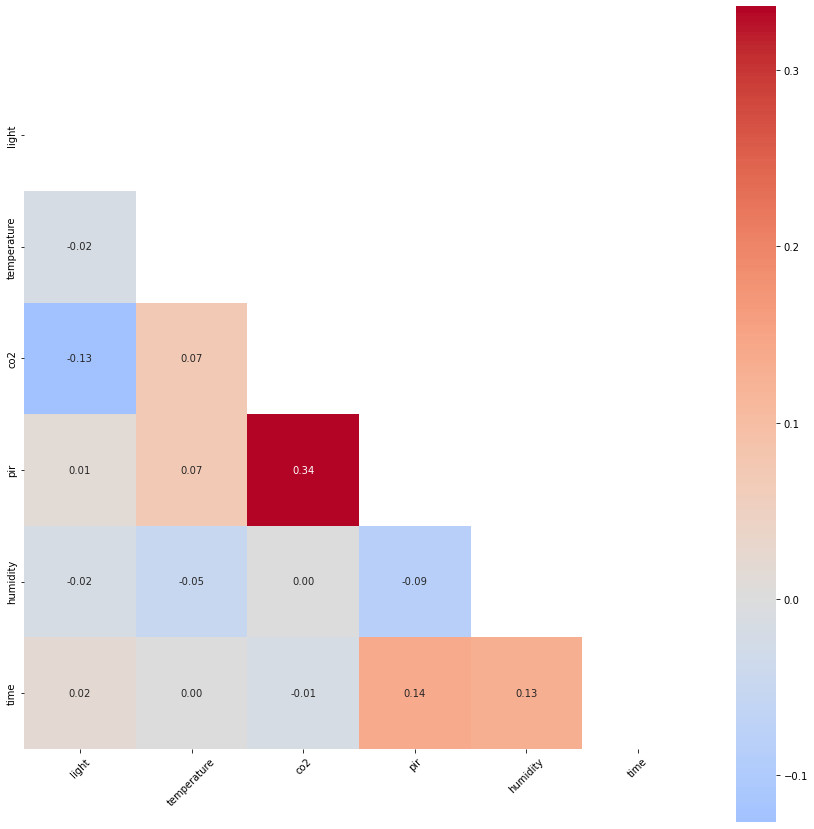

In [349]:
def dataCorr(data):
    data_corr = data.corr()
    mask = np.zeros_like(data_corr)
    mask[np.triu_indices_from(mask)] = True
    plt.subplots(figsize=(15, 15))
    dataplot = sns.heatmap(data_corr, annot=True, cmap="coolwarm", mask=mask, center=0, square=True, fmt=".2f")
    plt.xticks(rotation = 45)
    plt.show()
    
dataCorr(data)

In [350]:
data.index.duplicated()
data.reset_index(drop=True, inplace=True)

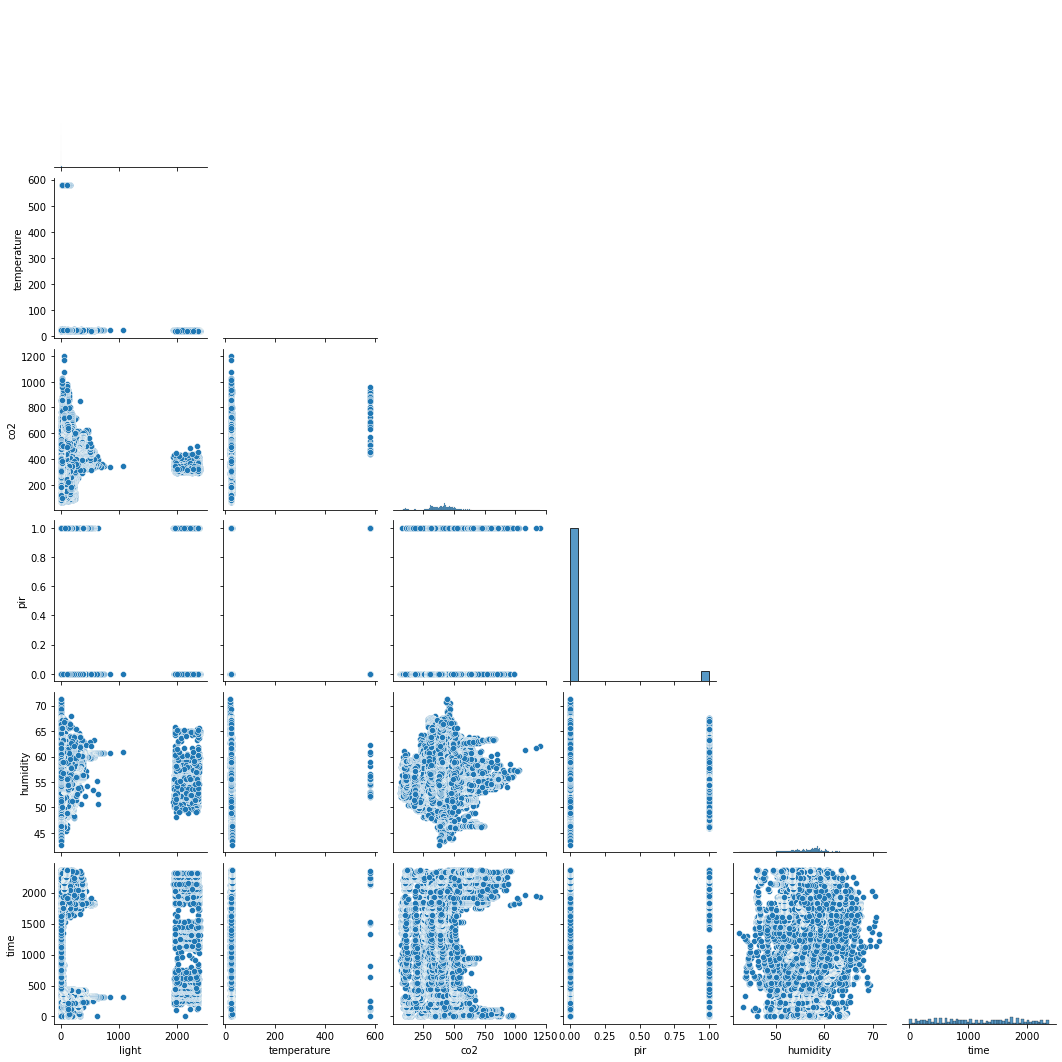

In [351]:
sns.pairplot(data, corner=True)

<AxesSubplot:xlabel='time', ylabel='pir'>

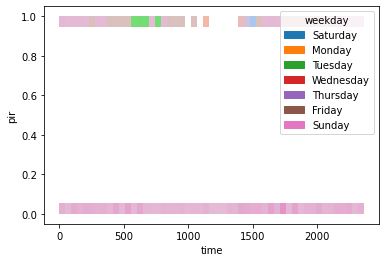

In [352]:
sns.histplot(x=data["time"], y=data["pir"], hue=data["weekday"])

In [353]:
data["temperature"].mean()

23.3792240102298

In [354]:
# sns.histplot(data["temperature"])
data["temperature"].describe()

count    128262.000000
mean         23.379224
std          11.014160
min          20.200000
25%          22.610000
50%          23.110000
75%          23.650000
max         579.270000
Name: temperature, dtype: float64

In [355]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data["weekday"] = le.fit_transform(data["weekday"])

In [356]:
data["weekday"].describe()

count    128262.000000
mean          2.682922
std           1.880560
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max           6.000000
Name: weekday, dtype: float64

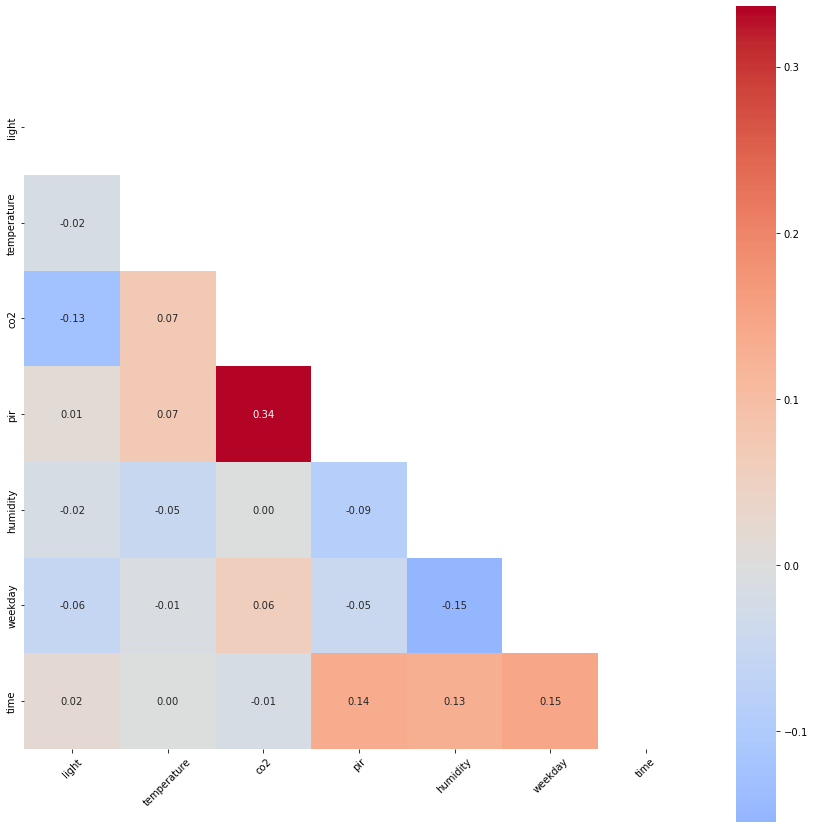

In [357]:
dataCorr(data)

## Modeling